In [3]:
# --- Importación de librerías ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings("ignore")

# --- Generación de Datos Sintéticos (tu código) ---
np.random.seed(2)
n_samples = 50000
start_date = datetime(2024, 1, 1)
travel_dates = [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n_samples)]
max_capacity = np.random.choice([14, 30, 50], n_samples)
seat_number = (np.random.poisson(lam=10, size=n_samples) + (max_capacity / 2).astype(int)).clip(1, max_capacity)

# Crear el DataFrame con los datos generados
sinteticos_data = pd.DataFrame({
    'travel_date': travel_dates,
    'max_capacity': max_capacity,
    'seat_number': seat_number
})

print("--- DATOS SINTÉTICOS CREADOS CORRECTAMENTE ---")
print(sinteticos_data.head())


--- DATOS SINTÉTICOS CREADOS CORRECTAMENTE ---
  travel_date  max_capacity  seat_number
0  2024-06-17            14           14
1  2024-01-16            50           33
2  2024-03-13            30           23
3  2024-01-23            30           26
4  2024-10-26            50           37


In [4]:
# --- Preparación de la Serie Temporal ---
# Agrupar los datos por fecha y sumar el número de asientos para crear la serie temporal
serie_temporal = sinteticos_data.groupby('travel_date')['seat_number'].sum().sort_index()

print("\n--- SERIE TEMPORAL CREADA (PRIMEROS 5 DÍAS) ---")
print(serie_temporal.head())

# --- Creación de Variables Exógenas (Días de la semana) ---
# Se crean columnas binarias para cada día de la semana
exog = pd.get_dummies(serie_temporal.index.day_name(), prefix='dia', drop_first=False)
exog.index = serie_temporal.index

# Reordenar las columnas para que sigan el orden lógico de la semana
dias_ordenados = ['dia_Monday', 'dia_Tuesday', 'dia_Wednesday', 'dia_Thursday', 'dia_Friday', 'dia_Saturday', 'dia_Sunday']
exog = exog.reindex(columns=dias_ordenados)

print("\n--- VARIABLES EXÓGENAS CREADAS (PRIMEROS 5 DÍAS) ---")
print(exog.head())



--- SERIE TEMPORAL CREADA (PRIMEROS 5 DÍAS) ---
travel_date
2024-01-01    3568
2024-01-02    3695
2024-01-03    3534
2024-01-04    3313
2024-01-05    3614
Name: seat_number, dtype: int64

--- VARIABLES EXÓGENAS CREADAS (PRIMEROS 5 DÍAS) ---
             dia_Monday  dia_Tuesday  dia_Wednesday  dia_Thursday  dia_Friday  \
travel_date                                                                     
2024-01-01         True        False          False         False       False   
2024-01-02        False         True          False         False       False   
2024-01-03        False        False           True         False       False   
2024-01-04        False        False          False          True       False   
2024-01-05        False        False          False         False        True   

             dia_Saturday  dia_Sunday  
travel_date                            
2024-01-01          False       False  
2024-01-02          False       False  
2024-01-03          False     

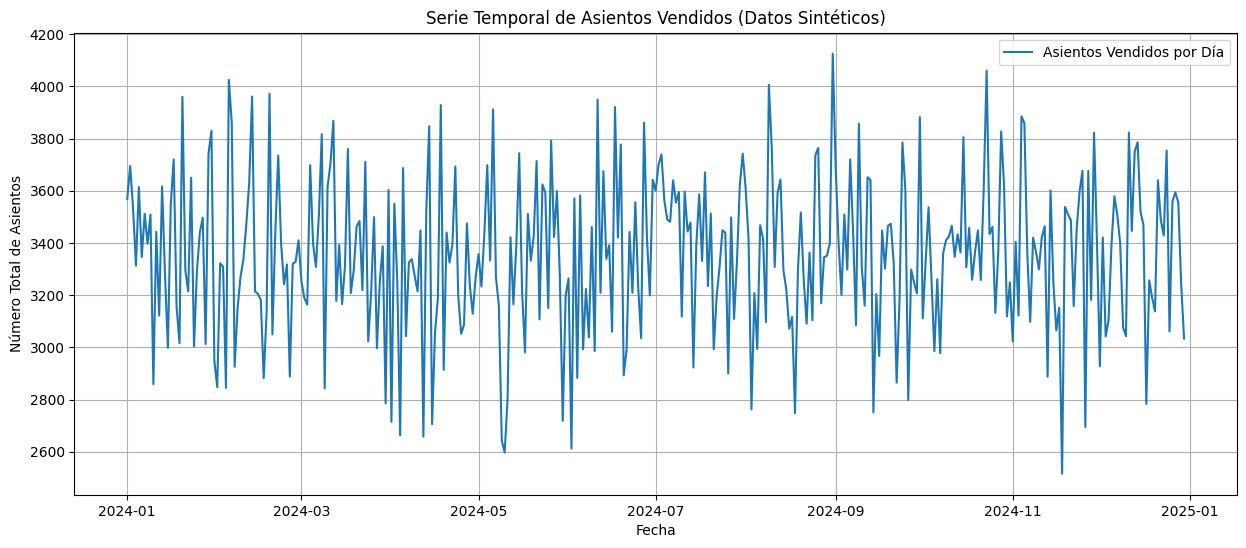


--- Resultados de la Prueba de Dickey-Fuller Aumentada ---
Test Statistic                 -19.664742
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64

Conclusión: La serie es estacionaria (p-value <= 0.05).


In [5]:
# --- Visualización de la Serie Temporal Original ---
plt.figure(figsize=(15, 6))
plt.plot(serie_temporal, label='Asientos Vendidos por Día')
plt.title('Serie Temporal de Asientos Vendidos (Datos Sintéticos)')
plt.xlabel('Fecha')
plt.ylabel('Número Total de Asientos')
plt.legend()
plt.grid(True)
plt.show()

# --- Función para la Prueba de Estacionariedad (Dickey-Fuller) ---
def prueba_estacionariedad(timeseries):
    print('\n--- Resultados de la Prueba de Dickey-Fuller Aumentada ---')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] <= 0.05:
        print("\nConclusión: La serie es estacionaria (p-value <= 0.05).")
    else:
        print("\nConclusión: La serie no es estacionaria (p-value > 0.05).")

# --- Realizar la prueba en la serie ---
prueba_estacionariedad(serie_temporal)


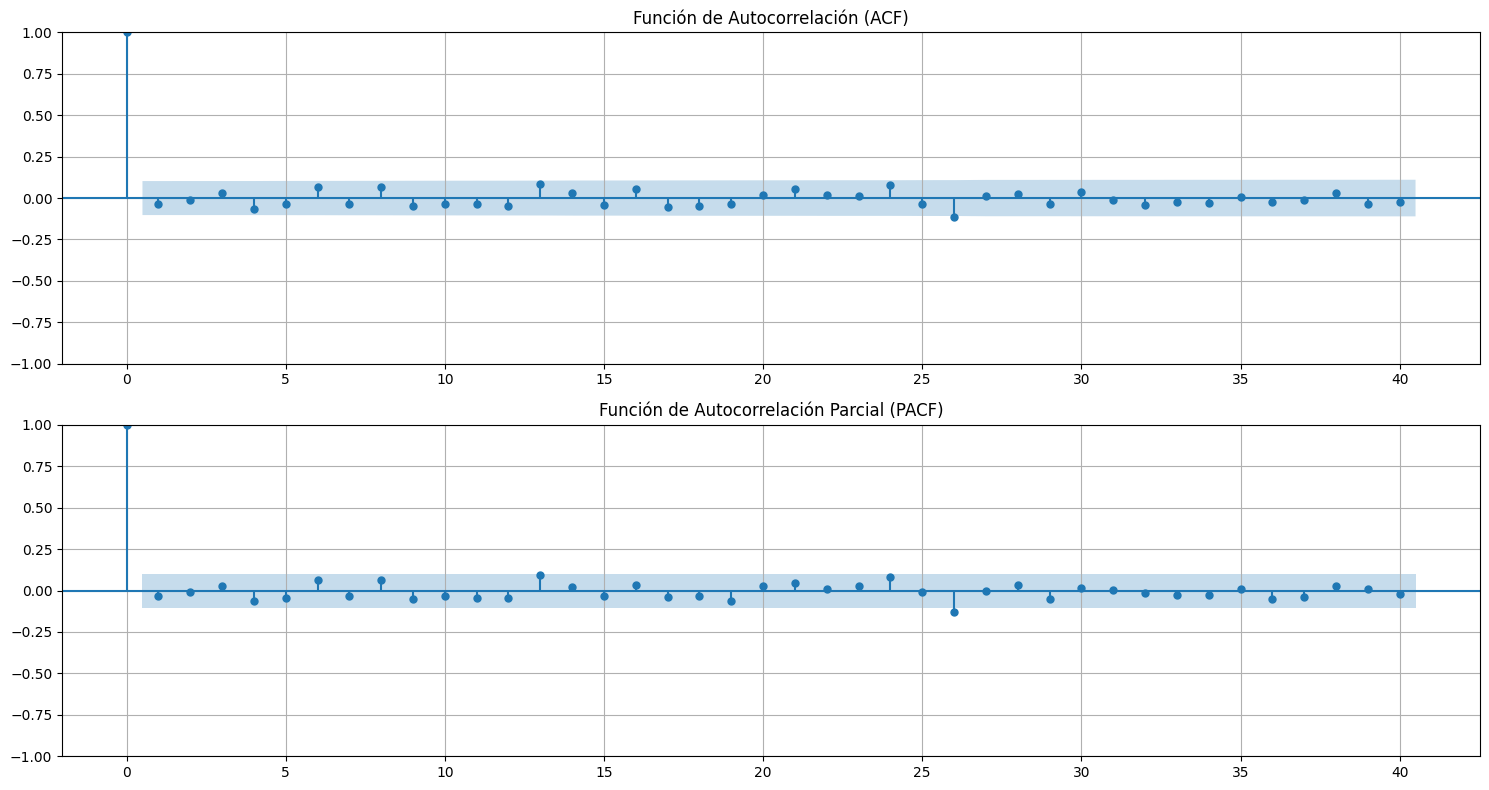

In [6]:
# --- Gráficas de Autocorrelación y Autocorrelación Parcial ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Gráfica ACF
plot_acf(serie_temporal, ax=ax1, lags=40)
ax1.set_title('Función de Autocorrelación (ACF)')
ax1.grid(True)

# Gráfica PACF
plot_pacf(serie_temporal, ax=ax2, lags=40)
ax2.set_title('Función de Autocorrelación Parcial (PACF)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# --- División en datos de entrenamiento y prueba ---
train_size = int(len(serie_temporal) * 0.8)
train_series, test_series = serie_temporal[:train_size], serie_temporal[train_size:]
train_exog, test_exog = exog[:train_size], exog[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_series)} días")
print(f"Tamaño del conjunto de prueba: {len(test_series)} días")

# --- Entrenamiento del Modelo SARIMAX ---
# Un orden (1,0,1) es un buen punto de partida para series estacionarias.
# El componente más importante será 'exog', que captura el efecto del día de la semana.
model = SARIMAX(train_series, exog=train_exog, order=(1, 0, 1), freq='D')
model_fit = model.fit(disp=False)

# --- Mostrar el resumen del modelo ---
print("\n--- Resumen del Modelo SARIMAX Entrenado ---")
print(model_fit.summary())


Tamaño del conjunto de entrenamiento: 292 días
Tamaño del conjunto de prueba: 73 días

--- Resumen del Modelo SARIMAX Entrenado ---
                               SARIMAX Results                                
Dep. Variable:            seat_number   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2069.268
Date:                Wed, 02 Jul 2025   AIC                           4158.536
Time:                        12:59:42   BIC                           4195.304
Sample:                    01-01-2024   HQIC                          4173.264
                         - 10-18-2024                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
dia_Monday     3401.1429     39.509     86.085      0.000    3323.706   


--- RMSE (Error Cuadrático Medio) de Prueba: 302.085 ---


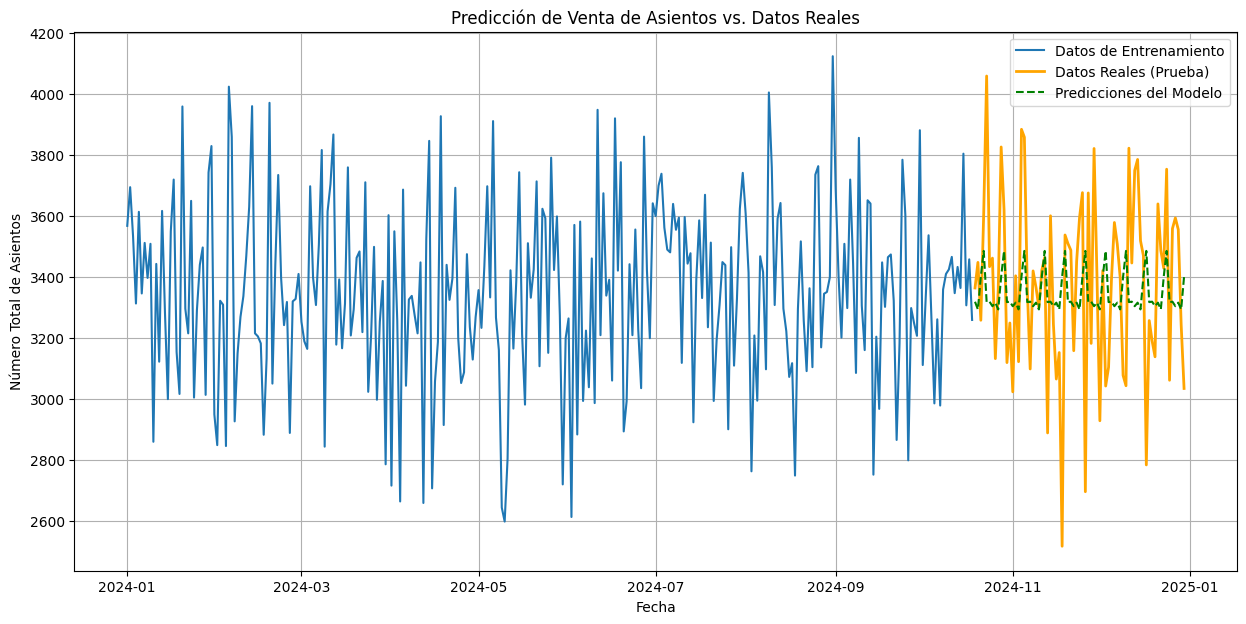

In [8]:
# --- Realizar predicciones sobre el conjunto de prueba ---
predictions = model_fit.predict(start=test_series.index[0], end=test_series.index[-1], exog=test_exog)

# --- Calcular el Error Cuadrático Medio (RMSE) ---
rmse = np.sqrt(mean_squared_error(test_series, predictions))
print(f"\n--- RMSE (Error Cuadrático Medio) de Prueba: {rmse:.3f} ---")

# --- Visualización de los resultados ---
plt.figure(figsize=(15, 7))
plt.plot(train_series.index, train_series, label='Datos de Entrenamiento')
plt.plot(test_series.index, test_series, label='Datos Reales (Prueba)', color='orange', linewidth=2)
plt.plot(predictions.index, predictions, label='Predicciones del Modelo', color='green', linestyle='--')

plt.title('Predicción de Venta de Asientos vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Número Total de Asientos')
plt.legend()
plt.grid(True)
plt.show()
